In [6]:
import numpy as np
import os
import random
import time
np.random.seed(123)  # for reproducibility
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Convolution2D, MaxPooling2D, Reshape, Conv2DTranspose
from tensorflow.keras.datasets.mnist import load_data
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation,Flatten, Dropout, Convolution2D, MaxPooling2D, Input
from utilitaire import affiche


##################################################
# I - Load pre-shuffled MNIST data train and test sets
##################################################
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot

In [7]:
# Chargement et mise en forme des données
DATA_PATH = 'Data1/Data'
categories=["accordion", "anchor", "barrel", "binocular"]
for i in range(len(categories)):
    categories[i]=DATA_PATH + '/'+categories[i]
data = []

print(categories)

['Data1/Data/accordion', 'Data1/Data/anchor', 'Data1/Data/barrel', 'Data1/Data/binocular']


In [8]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(category)
        for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']]
    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x=np.array(img)
        x = np.expand_dims(x, axis=0)
        data.append({'x': np.array(x[0]), 'y':c})

num_classes = len(categories)
print("===========================================")
print(num_classes)
print("===========================================")
print(len(data))
print(data[0]['x'].shape)

4
177
(224, 224, 3)


In [9]:
random.shuffle(data)
#create train / val / test split
train_split = 0.7
idx_train = int(train_split * len(data))
train = data[:idx_train]
test = data[idx_train:]
#separate data and labels
X_train, y_train = np.array([t['x'] for t in train]), [t['y'] for t in train]
X_test, y_test = np.array([t['x'] for t in test]), [t['y'] for t in test]
#normalize data
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
#convert labels to one-hot vectors
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('finished loading',len(data),'images from',num_classes,'categories')
print('train / test split:', len(X_train), len(X_test))
print('training data shape: ', X_train.shape)
print('training label shape: ', len(y_train))
print('test data shape: ', X_test.shape)

finished loading 177 images from 4 categories
train / test split: 123 54
training data shape:  (123, 224, 224, 3)
training label shape:  123
test data shape:  (54, 224, 224, 3)


- X_train a une taille de 123
- X_test a une taille de 54

- y_train a une taille de 123
- y_test a une taille de 54


On a fait un pre processing des données pour avoir la même taille pour les données d'entrainement et de test.



In [16]:
print(X_train.shape)

print(type(X_train))

(123, 224, 224, 3)
<class 'numpy.ndarray'>


# image de taille 224x224*3 car RGB

taille de l'image :  (224, 224, 3)
taille de l'image :  (224, 224, 3)
taille de l'image :  (224, 224, 3)


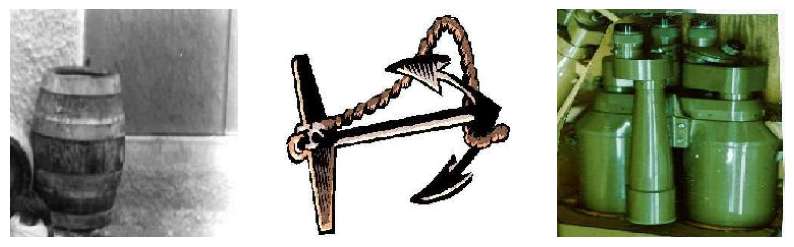

In [11]:
#affichage des images
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

    print("taille de l'image : ", X_train[i].shape)



# Apprentissage d'un modele convolutif

1) Input ==> image
2) Convolution filtre 3x3
3) Convolution filtre 3x3
4) Flatten
5) couches fully connected 256
6) couches fully connected 256
7) softmax

In [12]:
#input = taille de l'image
inputs = Input(shape=(224, 224, 3))
x = inputs


x=Convolution2D(32, kernel_size=(3,3), activation='relu')(x)
x=MaxPooling2D(pool_size=(2,2),strides=2)(x)

x=Convolution2D(64, kernel_size=(3,3), activation='relu')(x)
x=MaxPooling2D(pool_size=(2,2),strides=2)(x)

x=Flatten()(x)
x=Dense(256, activation='relu')(x)
outputs=Dense(4, activation='softmax')(x)

model_CNN = Model(inputs, outputs)

print("Nombre de paramètres : ", model_CNN.count_params())

model_CNN.summary()

Nombre de paramètres :  47796420
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)          

2023-12-15 22:40:36.012205: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191102976 exceeds 10% of free system memory.
2023-12-15 22:40:36.074872: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191102976 exceeds 10% of free system memory.
2023-12-15 22:40:36.096392: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191102976 exceeds 10% of free system memory.


# Entrainement

Ajouter un stride permet de diminuer le nombre de paramètres.

In [13]:
lr= 0.01
batch_size= 64
epochs=50

sgd1= tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model_CNN.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.time()


history =model_CNN.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(X_test, Y_test))
affiche(history)

# Evaluation du modèle sur les données de test
score = model_CNN.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model_CNN.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Epoch 1/50


2023-12-15 22:40:36.622341: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191102976 exceeds 10% of free system memory.
2023-12-15 22:40:36.934785: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 191102976 exceeds 10% of free system memory.


2/2 [==============================] - 4s 2s/step - loss: 1.5371 - accuracy: 0.2602 - val_loss: 1.3695 - val_accuracy: 0.2222
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 1.2501 - accuracy: 0.4309 - val_loss: 1.2055 - val_accuracy: 0.5741
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 1.0819 - accuracy: 0.6992 - val_loss: 1.1958 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.5854

KeyboardInterrupt: 

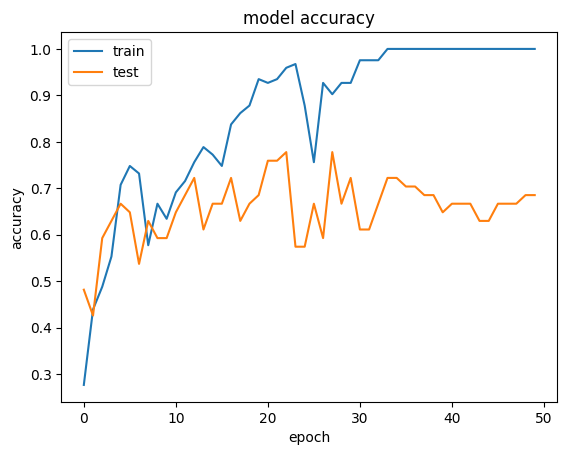

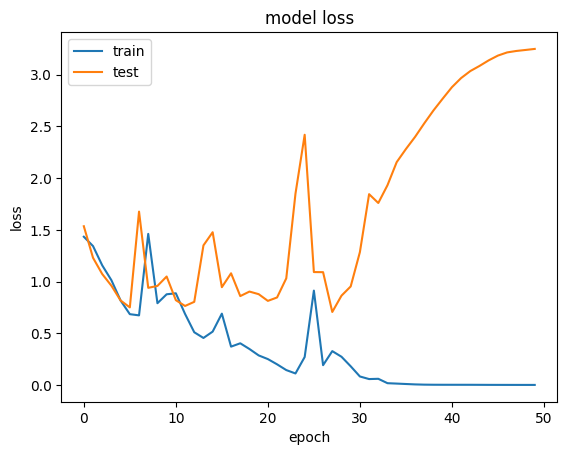

Test accuracy: 0.6851851940155029


In [ ]:
affiche(history)
print('Test accuracy:', score[1])


# Transfert Learning

VGG a été appris sur Image Net
Pour nous, on va recuperer les parametres ,sauf celle de la derniere couche, et on va les utiliser pour notre probleme.

In [ ]:
input_tensor = Input(shape=(224,224,3))

model = tf.keras.applications.VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)
model.summary()
#extraction des features
feature_train = model.predict(X_train)
feature_test = model.predict(X_test)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

On a donc extrait :

- feature_train : les features de l'ensemble d'entrainement
- feature_test : les features de l'ensemble de test

Cela signifie que l'on a fait passer les images dans le reseau VGG et on a recuperer les features de la couche avant la derniere couche.

In [ ]:
print(feature_train.shape)
print(feature_test.shape)

(123, 7, 7, 512)
(54, 7, 7, 512)


taille de l'image :  (7, 7)
taille de l'image :  (7, 7)
taille de l'image :  (7, 7)


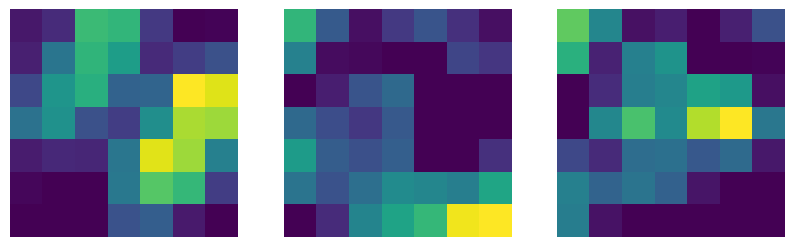

In [ ]:
#visualisation des features
plt.figure(figsize=(10,10))

#il faut prendre 1 image sur la profondeur
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(feature_train[i,:,:,0])
    plt.axis('off')

    print("taille de l'image : ", feature_train[i,:,:,0].shape)

Construire un réseau MLP à une couche cachée qui prend en entrée ces caractéristiques et prédit la classe des images.


In [ ]:
#construction du modèle

input = Input(shape=(7,7,512))
x = input
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(input, output)
print("Nombre de paramètres : ", model.count_params())


Nombre de paramètres :  6423812


## Apprentissage

Epoch 1/10
2/2 [==============================] - 1s 209ms/step - loss: 3.6201 - accuracy: 0.1789 - val_loss: 9.8048 - val_accuracy: 0.2593
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 6.9897 - accuracy: 0.3089 - val_loss: 2.6802 - val_accuracy: 0.3704
Epoch 3/10
2/2 [==============================] - 0s 77ms/step - loss: 2.1836 - accuracy: 0.4959 - val_loss: 1.3340 - val_accuracy: 0.5185
Epoch 4/10
2/2 [==============================] - 0s 76ms/step - loss: 1.2693 - accuracy: 0.6829 - val_loss: 1.2563 - val_accuracy: 0.7222
Epoch 5/10
2/2 [==============================] - 0s 70ms/step - loss: 1.1922 - accuracy: 0.7073 - val_loss: 1.1913 - val_accuracy: 0.6296
Epoch 6/10
2/2 [==============================] - 0s 101ms/step - loss: 1.2087 - accuracy: 0.5366 - val_loss: 1.1967 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 67ms/step - loss: 1.1720 - accuracy: 0.5366 - val_loss: 1.2194 - val_accuracy: 0.5185
Epoch 8/10
2/2 [=========

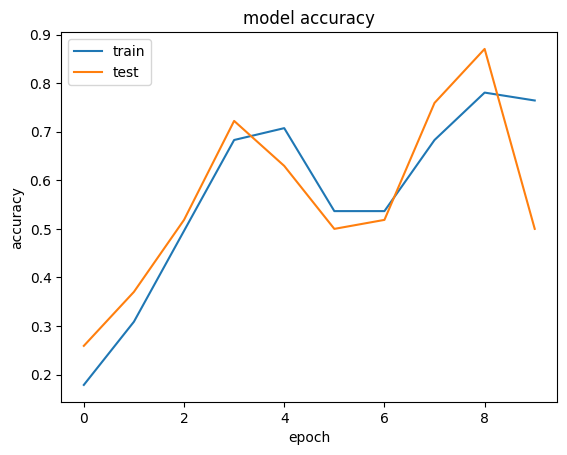

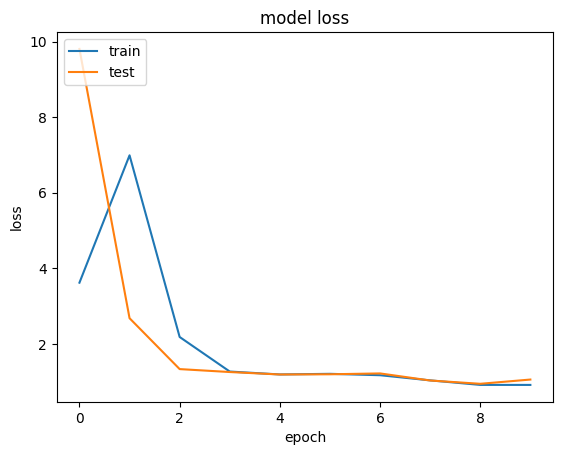

Test loss: 1.057435393333435
Test accuracy: 0.5


In [ ]:
lr= 0.01
batch_size= 64
epochs=10


sgd1= tf.keras.optimizers.SGD(learning_rate=lr)


model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.time()


history =model.fit(feature_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(feature_test, Y_test))
tps2 = time.time()

affiche(history)

# Evaluation du modèle sur les données de test
score = model.evaluate(feature_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

__Le resultat est meilleur !__

# Auto encodeur

In [ ]:
(X_train, y_train), (X_test, y_test) = load_data() # Chargement des données de MNIST
X_train, pipo, y_train, pipo = train_test_split(X_train, y_train, test_size=0.9)
X_test, pipo, y_test, pipo = train_test_split(X_test, y_test, test_size=0.9)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#APRES : (60000, 28, 28, 1)

X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)

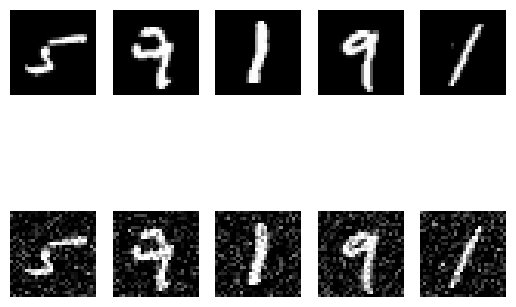

In [ ]:
X_train_noise = X_train + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noise = np.clip(X_train_noise, 0.0, 1.0)
X_test_noise = np.clip(X_test_noise, 0.0, 1.0)

# Display the train data and a version of it with added noise
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
  plt.subplot(2,5,i+6)
  plt.imshow(X_train_noise[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()




In [ ]:
print("il y a ", X_train.shape[0], "images de taille ", X_train.shape[1], "x", X_train.shape[2], "x", X_train.shape[3])
print("il y a  ", Y_train.shape[1], "classes")

il y a  6000 images de taille  28 x 28 x 1
il y a   10 classes


La fonction np.clip permet de mettre les valeurs de la matrice entre 0 et 1.

### Définition du reseau

In [ ]:
# partie encodeur


input = Input(shape=(28,28,1))
x = input
x = Convolution2D(32, kernel_size=(3,3), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)


x = Convolution2D(32, kernel_size=(3,3), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)


#partie decodeur : une convolution transposee avec stride 2

x = Conv2DTranspose(32, kernel_size=(3,3), strides=2, activation='relu',padding='same')(x)
x = Conv2DTranspose(32, kernel_size=(3,3), strides=2, activation='relu',padding='same')(x)

#ici, on esta 19x19x32
#une couche de convoluution pour avoir en sortie 1 image de taille 28x28 en niveau de gris
# 19 19 1 et on veut 28 28 1 en sortie : il faut donc un padding de 4
output = Convolution2D(1, kernel_size=(3,3), strides=1,padding='same', activation='linear')(x)



encodeur = Model(input, output)

#summary
encodeur.summary()

print("Nombre de paramètres : ", encodeur.count_params())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248

backbone = taille sortie encoder = 4 4 32

# Apprentissage

In [ ]:

opt = keras.optimizers.Adam(learning_rate=0.0005)

encodeur.compile(loss="mse", optimizer=opt,metrics=['accuracy'])

#train : attention, l'erreur est entre l'input (bruité) et l'output (reconstruction)
history = encodeur.fit(X_train_noise, X_train, batch_size=64, epochs=100, verbose=1,validation_data=(X_test_noise, X_test))
affiche(history)

Epoch 1/100
94/94 [==============================] - 7s 63ms/step - loss: 0.0611 - accuracy: 0.8081 - val_loss: 0.0373 - val_accuracy: 0.8077
Epoch 2/100
94/94 [==============================] - 6s 61ms/step - loss: 0.0235 - accuracy: 0.8092 - val_loss: 0.0254 - val_accuracy: 0.8100
Epoch 3/100
94/94 [==============================] - 6s 59ms/step - loss: 0.0176 - accuracy: 0.8119 - val_loss: 0.0231 - val_accuracy: 0.8102
Epoch 4/100
94/94 [==============================] - 6s 59ms/step - loss: 0.0151 - accuracy: 0.8128 - val_loss: 0.0218 - val_accuracy: 0.8106
Epoch 5/100
94/94 [==============================] - 6s 61ms/step - loss: 0.0136 - accuracy: 0.8133 - val_loss: 0.0211 - val_accuracy: 0.8100
Epoch 6/100
94/94 [==============================] - 6s 63ms/step - loss: 0.0125 - accuracy: 0.8136 - val_loss: 0.0205 - val_accuracy: 0.8095
Epoch 7/100
94/94 [==============================] - 6s 64ms/step - loss: 0.0117 - accuracy: 0.8139 - val_loss: 0.0198 - val_accuracy: 0.8110
Epoch 

KeyboardInterrupt: 

In [ ]:
#on predit sur les données de test
X_test_pred = encodeur.predict(X_test_noise)


In [ ]:
#on affiche les images bruitées, les images reconstruites et les images originales
for i in range(5):
  plt.subplot(3,5,i+1)
  plt.imshow(X_test[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')


  plt.subplot(3,5,i+6)
  plt.imshow(X_test_noise[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')


  plt.subplot(3,5,i+11)
  plt.imshow(X_test_pred[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')

#titre sur la 1ere ligne
plt.subplot(3,5,1)
plt.title("Original")
plt.subplot(3,5,6)
plt.title("Noisy")
plt.subplot(3,5,11)
plt.title("Reconstruit")
plt.show()



# Variational Auto-encodeur

In [ ]:
#on reprends MNIST


# load dataset
(X_train, y_train), (X_test, y_test) = load_data() # Chargement des données de MNIST
X_train, pipo, y_train, pipo = train_test_split(X_train, y_train, test_size=0.9)
X_test, pipo, y_test, pipo = train_test_split(X_test, y_test, test_size=0.9)



X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#APRES : (60000, 28, 28, 1)

X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)



In [ ]:
def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample


def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss


    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss



# Encodeur

In [ ]:
#u encodeur)(x)

input = Input(shape=(28,28,1))
x = input


x = Convolution2D(32, kernel_size=(3,3), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)


x = Convolution2D(32, kernel_size=(3,3), activation='relu',padding='same')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)

x=Flatten()(x)

#couche dense de taille 16
x=Dense(16, activation="relu")(x)

mu = Dense(2)(x)
log_variance = Dense(2)(x)
encoder_output = tf.keras.layers.Lambda(sampling)([ mu, log_variance])


#on definit le modele encodeur
encodeur = Model(input, encoder_output)

#summary

encodeur.summary()


- mu represente la moyenne du vecteur latent
- sigma represente la variance.

In [ ]:
print(mu.shape)
print(log_variance.shape)
print(encoder_output.shape)

## Decodeur

Il prend en entree un vecteur de taille 2 et le transforme en une image de taille 28x28x1

In [ ]:
#DECODEUR

x=Dense(7*7*32, activation="relu")(encoder_output)

#on reshape pour avoir 7 7 32
x=Reshape((7,7,32))(x)

#une couche de convolution transposee 
x=Conv2DTranspose(32, kernel_size=(3,3), strides=2, activation='relu',padding='same')(x)
x=Conv2DTranspose(32, kernel_size=(3,3), strides=2, activation='relu',padding='same')(x)

x= Convolution2D(1,kernel_size=(3,3),strides=1,activation='linear',padding='same')(x)
# on veut en sortie une image 28 28 1 

vae = Model(input, x)

vae.summary()

# VAE

In [ ]:
#on realise l'apprentissage pour pouvoir mieux 

vae.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.0005), loss=loss_func(mu, log_variance), metrics=['accuracy'])
vae.fit(X_train, X_train, epochs=100, batch_size=64, shuffle=True, validation_data=(X_test, X_test))

In [ ]:
#evaluation du modele
score = vae.evaluate(X_test, X_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


#on predit sur les données de test
X_test_gen = vae.predict(X_test)




In [ ]:
#on affiche les images bruitées, les images reconstruites et les images originales
random.seed(90)
#affiche random

#tableau indices de 5 valeurs aleatoires
indices = random.sample(range(0, len(X_test)), 5)
print(indices)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow(X_test[indices[i],:].reshape([28,28]), cmap='gray')
  plt.axis('off')


  plt.subplot(2,5,i+6)
  plt.imshow(X_test_gen[indices[i],:].reshape([28,28]), cmap='gray')
  plt.axis('off')



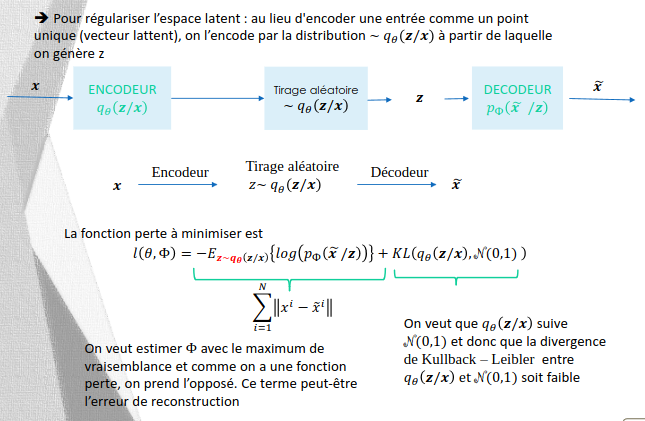
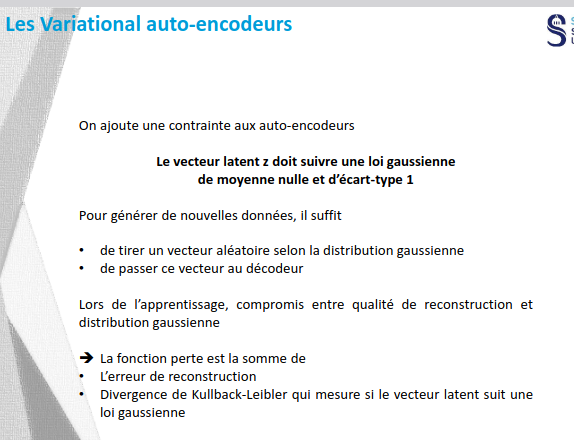
